In [1]:
import components
import materials
import openmc

import math

In [2]:
beryllium = materials.beryllium
my_materials = openmc.Materials([beryllium])
my_materials.export_to_xml()

In [3]:
plasma_nodes = [[10, 0], [12, -1], [13, 0], [12,2]]
vessel_nodes = [[9, 0], [12, -2], [14, 0], [12,3]]

In [4]:
reflective_lower = openmc.YPlane(
    y0=0, boundary_type='reflective').rotate([0, 0, -10])
reflective_upper = openmc.YPlane(
    y0=0, boundary_type='reflective').rotate([0, 0, 10])

In [5]:
plasma = components.Plasma(nodes=plasma_nodes, boundary_1=reflective_lower, boundary_2=reflective_upper)
vacuum_vessel = components.VacuumVessel(nodes=vessel_nodes, thickness=1, material=beryllium, boundary_1=reflective_lower, boundary_2=reflective_upper)
sol = components.SOLVacuum(plasma=plasma, vacuum_vessel=vacuum_vessel, boundary_1=reflective_lower, boundary_2=reflective_upper)
blanket = components.Blanket(vacuum_vessel = vacuum_vessel, thickness =1, material=beryllium, boundary_1=reflective_lower, boundary_2=reflective_upper)
shield = components.Shield(blanket=blanket, thickness=1, material=beryllium, boundary_1=reflective_lower, boundary_2=reflective_upper)

reactor_components = [plasma, vacuum_vessel, blanket, shield]

TypeError: Plasma.__init__() got an unexpected keyword argument 'nodes'

In [ ]:
sphere = openmc.Sphere(r=25, boundary_type='vacuum')
enclosure_region = -sphere
for rc in reactor_components:
    enclosure_region = enclosure_region & ~(rc.region)
enclosure_cell = openmc.Cell(region=enclosure_region, fill=None)

In [ ]:
geometry=openmc.Geometry([plasma.cell, vacuum_vessel.cell, sol.cell, blanket.cell, shield.cell, enclosure_cell])
geometry.export_to_xml()

In [ ]:
settings = openmc.Settings()

settings.photon_transport = False
settings.run_mode = 'fixed source'
# source definition
source = openmc.Source()
source.particle = 'neutron'
radius = openmc.stats.Discrete([620], [1])
z_values = openmc.stats.Discrete([0], [1])
angle = openmc.stats.Uniform(a=math.radians(0), b=math.radians(360))
source.space = openmc.stats.CylindricalIndependent(
    r=radius, phi=angle, z=z_values, origin=(0., 0., 0.))
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete(14.1e6, 1)

# settings' settings
# weight windows from wwinp
settings.source = source
settings.survival_biasing = False
settings.batches = 100
settings.particles = int(1e6)

settings.export_to_xml()

/home/segantin/openmc/openmc/source.py:388: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [8]:
tf_in = (
    [641, 0],
    [633, 77],
    [616, 165],
    [592, 238],
    [532, 351],
    [476, 410],
    [397, 449],
    [343, 466],
    [250, 465],
    [181, 452],
    [128, 403],
    [107, 336],
    [107, 0],
    [107, -336],
    [128, -403],
    [181, -452],
    [250, -465],
    [343, -466],
    [397, -449],
    [476, -410],
    [532, -351],
    [592, -238],
    [616, -165],
    [633, -77],
)  # magnet thickness=9, insulation=14, case=14

tfcoil = components.TFCoilMagnet(tf_in, 9,beryllium, (-10,10))

reactor_components = [tfcoil]

sphere = openmc.Sphere(r=10000, boundary_type='vacuum')
enclosure_region = -sphere
for rc in reactor_components:
    enclosure_region = enclosure_region & ~(rc.region)
enclosure_cell = openmc.Cell(region=enclosure_region, fill=None)

geometry=openmc.Geometry([tfcoil.cell, enclosure_cell])
geometry.export_to_xml()


settings = openmc.Settings()

settings.photon_transport = False
settings.run_mode = 'fixed source'
# source definition
source = openmc.Source()
source.particle = 'neutron'
radius = openmc.stats.Discrete([620], [1])
z_values = openmc.stats.Discrete([0], [1])
angle = openmc.stats.Uniform(a=math.radians(0), b=math.radians(360))
source.space = openmc.stats.CylindricalIndependent(
    r=radius, phi=angle, z=z_values, origin=(0., 0., 0.))
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete(14.1e6, 1)

# settings' settings
# weight windows from wwinp
settings.source = source
settings.survival_biasing = False
settings.batches = 100
settings.particles = int(1e6)

settings.export_to_xml()

QhullError: QH6013 qhull input error: input is less than 2-dimensional since all points have the same x coordinate  107

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 877641677  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 6.7e+02  Error-roundoff 2.7e-13  _one-merge 1.4e-12
  _near-inside 6.8e-12  Visible-distance 5.5e-13  U-max-coplanar 5.5e-13
  Width-outside 1.1e-12  _wide-facet 3.3e-12  _maxoutside 1.6e-12


In [1]:
import openmc
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

In [2]:
cwd = os.getcwd()

In [3]:
os.chdir('../../reactors/iter_class/')

In [4]:
ww = openmc.wwinp_to_wws("weight_windows.cadis.wwinp")

In [5]:
for el in ww:
    print(el)

WeightWindows
	ID             =	1
	Mesh:          =	RectilinearMesh
	ID             =	1
	Name           =	
	Dimensions     =	3
	N X pnts:      =	26
	X Min:         =	-1e-09
	X Max:         =	1200.0
	N Y pnts:      =	26
	Y Min:         =	-250.0
	Y Max:         =	250.0
	N Z pnts:      =	26
	Z Min:         =	-700.0
	Z Max:         =	700.0

	Particle Type  =	neutron
	Energy Bounds  =	[0.00000e+00 2.14454e+02 1.58461e+03 7.10174e+03 2.18749e+04 2.60584e+04
 5.24752e+04 1.11090e+05 2.97211e+05 4.97871e+05 7.42736e+05 1.00259e+06
 1.65299e+06 2.23130e+06 2.36533e+06 2.72532e+06 3.67879e+06 6.06531e+06
 8.60708e+06 1.00000e+07 1.22140e+07 1.41907e+07 1.73325e+07]
	Lower WW Bounds=	[[[[7.422050e-03 1.190433e-02 1.072093e-02 ... 2.087727e-02
    1.730573e-02 2.283465e-02]
   [4.050221e-03 6.359990e-03 5.717711e-03 ... 1.104686e-02
    8.959231e-03 1.206553e-02]
   [2.787918e-03 4.349233e-03 3.919087e-03 ... 7.203827e-03
    5.826109e-03 7.860205e-03]
   ...
   [3.456489e-03 5.466932e-03 5.254832

In [6]:
wws = ww[0]
lb = wws.lower_ww_bounds
lb.shape

(25, 25, 25, 22)

In [7]:
wws.energy_bounds

array([0.00000e+00, 2.14454e+02, 1.58461e+03, 7.10174e+03, 2.18749e+04,
       2.60584e+04, 5.24752e+04, 1.11090e+05, 2.97211e+05, 4.97871e+05,
       7.42736e+05, 1.00259e+06, 1.65299e+06, 2.23130e+06, 2.36533e+06,
       2.72532e+06, 3.67879e+06, 6.06531e+06, 8.60708e+06, 1.00000e+07,
       1.22140e+07, 1.41907e+07, 1.73325e+07])

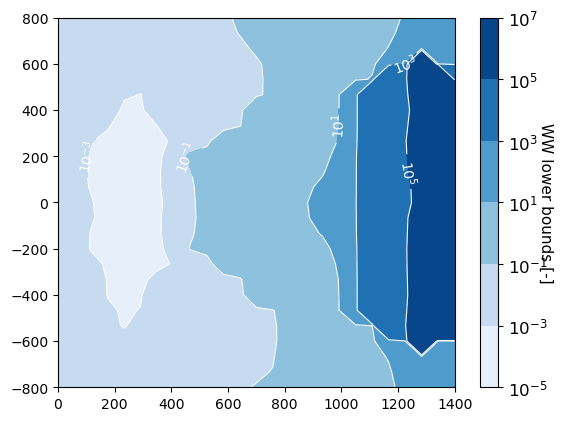

In [12]:
lbs = lb[:, :, 12, -2].T

x = np.linspace(0, 1400, 25)
y = np.linspace(-1200, 1200, 25)
z = np.linspace(-800, 800, 25)

fig, ax1 = plt.subplots()
fmt = ticker.LogFormatterSciNotation()
fmt.create_dummy_axis()
p1 = ax1.contourf(x, z, lbs, norm=LogNorm(), cmap='Blues')
p2 = ax1.contour(x, z, lbs, norm=LogNorm(), colors='w', linewidths=.8)
ax1.clabel(p2, fontsize=10, colors='w', fmt=fmt)
cbar1 = fig.colorbar(p1, ax=ax1)
cbar1.ax.tick_params(labelsize=12)
cbar1.ax.yaxis.set_major_formatter(ticker.LogFormatterSciNotation())
cbar1.set_label('WW lower bounds [-]', rotation=270, fontsize=11)
# 